# Find Label Errors in Multilabel (image) Datasets

This tutorial shows how you can use cleanlab to find potential label errors in multilabel datasets. In such datasets, each instance can be labeled with any of k labels, where k is the total number of different labels in the dataset.  Example applications in NLP include part-of-speech-tagging or entity recognition, which is the focus on this tutorial. Here we use the [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) which consists a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. We use a subset of the attributes in this tuturial 

- Eyeglasses (Person is wearing glasses)
- Wearing_Earrings (Person is wearing earings)
- Wearing_Hat (Person is wearing hat)
- Wearing_Necklace (Person is wearing a necklace)
- Wearing_Necktie (Person is wearing a necktie)
- No_Beard (beard is present)
- Smiling (Person is smiling)

**Overview of what we'll do in this tutorial:** 

- Find tokens with label issues using `cleanlab.filter.find_label_issues` with `multi_label = True`


<div class="alert alert-info">
Quickstart
<br/>
    
We have `multi_labels` and `pred_probs` from a model trained on an existing data? Run the code below to get improved consensus labels and more information about the quality of your labels and annotators.

<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```ipython3 
from cleanlab.filter import find_label_issues

noise_idx = find_label_issues(
        labels=dataset["labels"],
        pred_probs=dataset["pred_probs"],
        multi_label=True,
        return_indices_ranked_by='normalized_margin',
    )
```

    
</div>
</div>

## 1. Install required dependencies and download data

```ipython3
!pip install cleanlab
!pip install torchvision


# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git

Please download the dataset from https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
and unzip archive.zip here
```

In [1]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/MultilabelClassification/pred_probs.npy'
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/MultilabelClassification/data.csv'

File 'pred_probs.npy' already there; not retrieving.

File 'data.csv' already there; not retrieving.



In [2]:
import numpy as np
from cleanlab.filter import find_label_issues
import numpy as np
import os
import torchvision

import matplotlib.pyplot as plt
import pandas as pd

## 2. Get data, labels, and pred_probs

In multilabel classification tasks, each token in the dataset is labeled with one or more of *K* possible classes.
To find label issues, cleanlab requires predicted class probabilities from a trained classifier. These `pred_probs` contain a length-*K* vector for **each** token in the dataset.  Here we use `pred_probs` which are out-of-sample predicted class probabilities for a subset of the [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) dataset. Our example notebook ["Training Multilabel classification for images"](https://github.com/cleanlab/examples/blob/master/multilabel_classification/pytorch_network_training.ipynb) contains the code to produce such `pred_probs` and save them in a `.npz` file, which we simply load here. `data.csv` is a dataframe containing the labels.

In [3]:
pred_probs = np.load(open('pred_probs.npy','rb'))
df = pd.read_csv("data.csv").set_index("image_path")

`pred_probs` is a list(of size K) of numpy arrays, representing the probability that a given value belongs to class K

In [17]:
class_names = list(df.columns)

Classes of interest

In [19]:
print(class_names)

['Eyeglasses', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Necklace', 'Wearing_Necktie', 'No_Beard', 'Smiling']


In [5]:
labels=(df[class_names].to_numpy())


In [6]:

def convert_multilabel_y_to_list(y):
    yl = list()
    for i in range(y.shape[0]):
        yl.append(np.where(y[i,:])[0].tolist())
    return yl    

In [7]:
multi_labels = convert_multilabel_y_to_list(labels)

In [8]:
pred_labels = convert_multilabel_y_to_list(np.array((pred_probs>0.5),np.int32))

## 3. Use cleanlab to find label issues 

Based on the given labels and out-of-sample predicted probabilities, cleanlab can quickly help us identify label issues in our dataset. Here we request that the indices of the identified label issues be sorted by cleanlab’s normalized margin score, which measures the quality of each given label via the probability assigned to it in our model’s prediction. The returned `issues` are a list of indices `i`, which corresponds to a label issue at the `i`-th image sample in the dataset. These are the labels cleanlab thinks may be badly labeled in your dataset. 

In [9]:
issues = find_label_issues(pred_probs=pred_probs,labels=multi_labels,
                           multi_label=True,return_indices_ranked_by='normalized_margin')

In [14]:
def rep_dl(s):
    return os.getcwd()+'/archive/img_align_celeba/img_align_celeba/'+s

data2 = np.array([rep_dl(i) for i in df.index])


In [ ]:

def get_label_name(ls):
    return [class_names[i] for i in ls]

pred_label_names = [get_label_name(i) for i in pred_labels]
label_names = [get_label_name(i) for i in multi_labels]

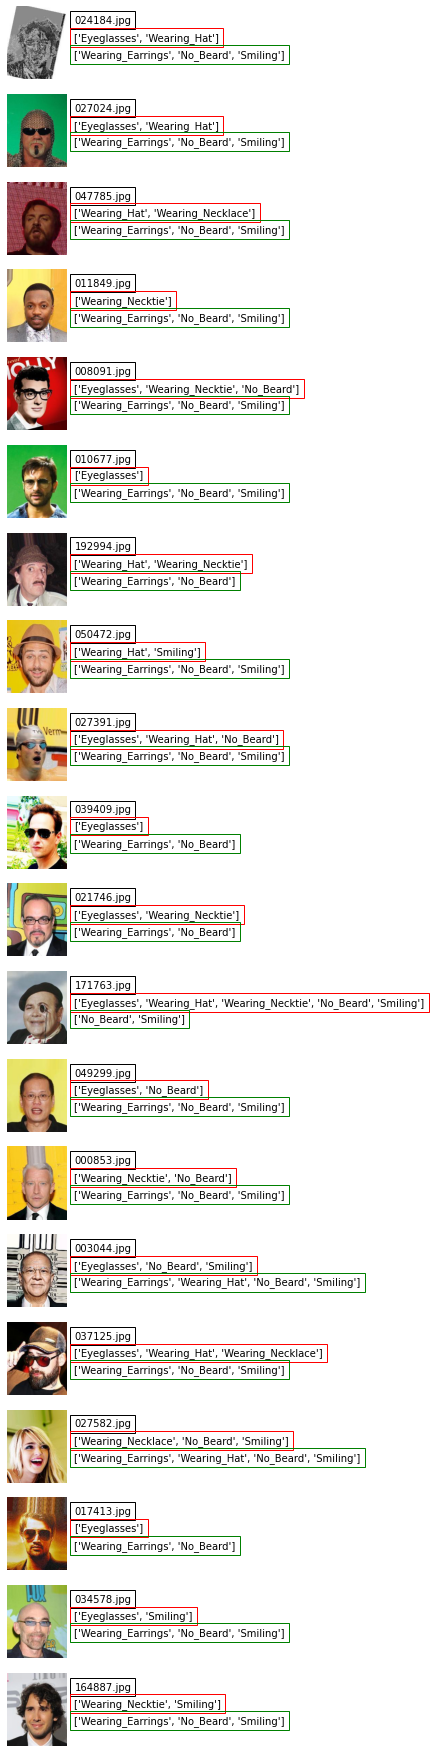

In [15]:
w = 10
h = 10
fig = plt.figure(figsize=(32, 32))
columns = 1
rows = 20
ct=0
for i in range(1, columns*rows +1):
    pos = issues[ct]
    label_error = label_names[pos]
    
    path = data2[pos]
    img = torchvision.io.read_image(path).swapaxes(0,2).swapaxes(0,1)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
    plt.text(200, 50, data2[pos].split('/')[-1], bbox=dict(fill=False, edgecolor='black', linewidth=1))
    plt.text(200, 100, label_error, bbox=dict(fill=False, edgecolor='red', linewidth=1))
    plt.text(200, 150, pred_label_names[pos], bbox=dict(fill=False, edgecolor='green', linewidth=1))
    ct+=1
plt.savefig("errors.pdf")